In [71]:
import pickle
import gzip
import scipy.stats as sps
import numpy as np
import os.path
import time

import dgl
from dgl.data.utils import download, extract_archive, get_download_dir

import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem import rdmolops
from bo import sascorer
import networkx as nx


import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

from jtnn import *


# from optparse import OptionParser
import argparse

torch.backends.cudnn.enabled=True

lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)


# We define the functions used to load and save objects
def save_object(obj, filename):
    result = pickle.dumps(obj)
    with gzip.GzipFile(filename, 'wb') as dest: dest.write(result)
    dest.close()


def load_object(filename):
    with gzip.GzipFile(filename, 'rb') as source: result = source.read()
    ret = pickle.loads(result)
    source.close()
    return ret


# parser = OptionParser()
"""
parser = argparse.ArgumentParser()
parser.add_argument("-v", "--vocab", dest="vocab_path", default="/home/ubuntu/ASAIL/jtnn_bo/jtnn/vocab.txt")
parser.add_argument("-m", "--model", dest="model_path", required=True)
parser.add_argument("-o", "--save_dir", dest="save_dir", required=True)
parser.add_argument("-n", "--n_train", dest="training_num", default=500)
parser.add_argument("-i", "--n_ind", dest="inducing_num", default=500)
parser.add_argument("-w", "--hidden", dest="hidden_size", default=200)
parser.add_argument("-l", "--latent", dest="latent_size", default=56)
parser.add_argument("-d", "--depth", dest="depth", default=3)
parser.add_argument("-r", "--seed", dest="random_seed", default=19)
parser.add_argument("-e", "--evaluate", dest="eval", default=False)
"""

vocab_path = "/home/ubuntu/ASAIL/jtnn_bo/jtnn/vocab.txt"
model_path = "model.iter-0-1500"
save_dir = "result/"
hidden_size = 200
latent_size = 56
depth = 3
random_seed = 1
training_num = 100000
inducing_num = 1000
#eval = "False"
eval = True


# We load the random seed
np.random.seed(int(random_seed))

# We load the data (y is minued!)
kkk = int(training_num)
M = int(inducing_num)
X = np.loadtxt('./bo/latent_features2.txt')[:kkk]
y = -np.loadtxt('./bo/targets2.txt')[:kkk]
y = y.reshape((-1, 1))
logP_values = np.loadtxt('./bo/logP_values2.txt')
SA_scores = np.loadtxt('./bo/SA_scores2.txt')
cycle_scores = np.loadtxt('./bo/cycle_scores2.txt')
SA_scores_normalized = (np.array(SA_scores) - np.mean(SA_scores)) / np.std(SA_scores)
logP_values_normalized = (np.array(logP_values) - np.mean(logP_values)) / np.std(logP_values)
cycle_scores_normalized = (np.array(cycle_scores) - np.mean(cycle_scores)) / np.std(cycle_scores)
#y = -logP_values
#y = y[:kkk].reshape((-1, 1))
#y = (np.array(y) - np.mean(y)) / np.std(y)


device = "cuda"
#device = "cpu"

n = X.shape[0]

permutation = np.random.choice(n, n, replace=False)

X_train = X[permutation, :][0: np.int(np.round(0.9 * n)), :]
X_test = X[permutation, :][np.int(np.round(0.9 * n)):, :]

y_train = y[permutation][0: np.int(np.round(0.9 * n))]
y_test = y[permutation][np.int(np.round(0.9 * n)):]

y_train = y_train.transpose()
y_test = y_test.transpose()


X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Train sparse Gaussian by gpytorch:

import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:M, :], likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
    
    
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)
print(y_train.shape, y_test.shape)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GPRegressionModel(X_train, y_train, likelihood).to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#training_iterations = 200
def train(training_iterations=100, optimizer=optimizer, X_train=X_train, y_train=y_train):
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train)
        loss.backward(retain_graph = True)
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        #torch.cuda.empty_cache()
if eval == "False":
    with gpytorch.settings.use_toeplitz(True):
        train()

torch.Size([90000]) torch.Size([10000])


In [72]:
# Load model 

state_dict = torch.load('result/SGPmodel_state.pth')
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
model = GPRegressionModel(X_train, y_train, likelihood)  # Create a new GP model
model.load_state_dict(state_dict) 
model.to(device).eval()
likelihood.to(device).eval()
#with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
#    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
#        preds = model(X_test)
#loss = -mll(preds, y_test)
#print("Test mll:", loss)

GaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
# Define helper function for BO
from scipy.stats import norm
import torch.nn.functional as F

def update_posterior(X_new, Y_new, iter=10):

    model.set_train_data(X_new, Y_new)
    # optimize the GP hyperparameters using Adam with lr=0.005
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    train(training_iteration=iter, optimizer=optimizer)

# Define Acquisition function
# TODO: the original paper uses expected imporvement 
def lower_confidence_bound(x, kappa=2):
    model.to(device)
    model.eval()
    mu, variance = model(x).mean, model(x).variance
    sigma = variance.sqrt()
    return mu - kappa * sigma

def find_a_candidate(x_init, lb, ub):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lb, ub)
    #print(x_init)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    #print(unconstrained_x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    
    # WARNING: this is a memory intensive optimizer
    # TODO: Maybe try other gradient-based iterative methods
    minimizer = optim.LBFGS([unconstrained_x], max_iter=10)

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        #y = lower_confidence_bound(unconstrained_x)
        #print(autograd.grad(y, unconstrained_x))
        print(y)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

def next_x(lb, ub, num_candidates_each_x=5, num_x=60):
    lb = lb.to(device)
    ub = ub.to(device)
    found_x=[]
    x_init = model.train_inputs[0][-1:].to(device)
    for j in range(num_x):
        candidates = []
        values = []
        for i in range(num_candidates_each_x):
            x = find_a_candidate(x_init, lb.to(device), ub.to(device))
            y = lower_confidence_bound(x)
            #print("next x:", x, x.shape)
            #print("next y:", y, y.shape)
            candidates.append(x)
            values.append(y)
            x_init = x.new_empty(1,56).uniform_(0, 1).mul(ub-lb).add_(lb).to(device)
            #print("next",x_init)
        argmin = torch.min(torch.cat(values), dim=0)[1].item()
        found_x.append(candidates[argmin])
        x_init=found_x[-1]
    return found_x

In [ ]:
device = "cpu"
lb = torch.min(X_train, dim = 0)[0]
ub = torch.max(X_train, dim = 0)[0]
xmin = next_x(lb,ub,5,60)

In [66]:
# try gpytorch Bayesian optimization:
# Define helper function for BO
from scipy.stats import norm
import torch.nn.functional as F

def update_posterior(X_new, Y_new, iter=50):
    #model.to("cuda")
    model.set_train_data(X_new, Y_new, strict = False)
    # optimize the GP hyperparameters using Adam with lr=0.005
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    train(training_iterations=iter, optimizer=optimizer)

# Define Acquisition function
# TODO: the original paper uses expected imporvement 
def lower_confidence_bound(x, kappa=0.5):
    model.eval()
    likelihood.eval()
    #with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    #    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
            #preds = model(x)
    with gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
        preds = model(x)
    mu, variance = preds.mean, preds.variance
    sigma = variance.sqrt()
    return mu - kappa * sigma

def expected_improvement(x):
    mu, variance = model(x, full_cov=False, noiseless=False)
    x_sample = model.X
    sigma = variance.sqrt()
    mu_sample, v_sample = model(X_sample, full_cov=False, noiseless=False)
    mu_sample_opt = torch.max(mu_sample)
    imp = mu - mu_sample
    z = imp / sigma
    ei = F.relu(imp) + sigma * norm.pdf(z) - torch.abs(imp) * norm.cdf(z)
    return ei
        
def find_a_candidate(x_init, lb, ub):

    def acquisition_minimizer(x_init, iterations=100):
        #x = x_init.clone().requires_grad_(True)
        x = x_init.requires_grad_(True)
        minimizer = optim.Adam([x], lr=0.01)
        for i in range(iterations):
            y = lower_confidence_bound(x)
            #print("iteration - {}: lower_confidence_bound: {}".format(i, y))
            autograd.backward(x, autograd.grad(y, x, retain_graph = True, allow_unused = True), retain_graph=True)
            #y.backward(retain_graph=True)
            #print(x.grad)
            minimizer.step()
        return x
    x = acquisition_minimizer(x_init)
 
    print("minimizer finished")
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    return x.detach()

def next_x(lb, ub, num_candidates_each_x=5, num_x=60):
    #device = "cuda"
    #model.to(device)
    #likelihood.to(device)
    found_x=[]
    lb = lb.to(device)
    ub = ub.to(device)
    x_init = model.train_inputs[0][-1:].to(device)
    for j in range(num_x):
        candidates = []
        values = []
        for i in range(num_candidates_each_x):
            print("start finding candidate")
            x = find_a_candidate(x_init, lb, ub)
            y = lower_confidence_bound(x)
            print(y)
            #print("next x:", x, x.shape)
            #print("next y:", y, y.shape)
            candidates.append(x)
            values.append(y)
            # require another random initialization
            #x_init = x.new_empty(1,56).uniform_(0, 1).mul(ub-lb).add_(lb).to("cuda")
            x_init = x.new_empty(1,56).normal_(0, 1).to("cuda")
            #print("next",x_init)
        argmin = torch.min(torch.cat(values), dim=0)[1].item()
        min_score = torch.min(torch.cat(values), dim=0)[0].item()
        print(min_score)
        found_x.append(candidates[argmin])
        x_init=found_x[-1]
    return found_x

In [35]:
lb = torch.min(X_train, dim = 0)[0]
ub = torch.max(X_train, dim = 0)[0]

In [19]:
xmin = next_x(lb,ub,5,5)

start finding candidate
minimizer finished
tensor([-9.4142], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-4.1175], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-5.9779], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-5.2321], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-5.0462], device='cuda:0', grad_fn=<SubBackward0>)
-9.414225578308105
start finding candidate
minimizer finished
tensor([-9.4469], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-4.8421], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-6.6488], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-6.0341], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-4.6696], de

In [25]:
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab)
JT_model = DGLJTNNVAE(vocab, hidden_size, latent_size, depth)
JT_model.load_state_dict(torch.load(model_path))
JT_model = cuda(JT_model)

In [73]:
#BO 5 times
max_iteration=5
for iteration in range(max_iteration):

    xmin = next_x(lb,ub,5,5)
    print("xmin:", len(xmin), xmin[0].shape)
    valid_smiles=[]
    scores=[]
    real_scores = []
    for x_new in xmin:
        #model = DGLJTNNVAE(vocab, hidden_size, latent_size, depth)
        #model.load_state_dict(torch.load(opts.model_path))
        #model = cuda(model)
        tree_vec, mol_vec = x_new.chunk(2,1)
        #print(x_new.shape, tree_vec.shape, mol_vec.shape)
        #print(x_new)
        s=JT_model.decode(tree_vec, mol_vec)
        if s is not None:
            valid_smiles.append(s)

            current_log_P_value = Descriptors.MolLogP(MolFromSmiles(s))
            current_SA_score = -sascorer.calculateScore(MolFromSmiles(s))
            cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(s))))
            if len(cycle_list) == 0:
                cycle_length = 0
            else:
                cycle_length = max([ len(j) for j in cycle_list ])
            if cycle_length <= 6:
                cycle_length = 0
            else:
                cycle_length = cycle_length - 6

            current_cycle_score = -cycle_length

            current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
            current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
            current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)

            score = current_SA_score_normalized + current_log_P_value_normalized + current_cycle_score_normalized
            y_new=-score
            scores.append(y_new)
            real_scores.append(current_log_P_value + current_SA_score - current_cycle_score)
            
            #print(gpmodel.X.shape)
            #print(x_new.shape)

            X = torch.cat((model.train_inputs[0], x_new.to("cuda")),0) # incorporate new evaluation

            #print(torch.tensor(y_new).float())
            print(model.train_targets.shape)
            print(torch.tensor([y_new]).shape)
            
            y = torch.cat((model.train_targets, torch.tensor([y_new]).float().to("cuda")),0)
            
            #print(y.shape)
            #print(y.type())
    if iteration < max_iteration-1:
        update_posterior(X, y)
        preds = model(X_train)
        RMSE = np.sqrt(np.mean((preds.mean.numpy() - y_test.numpy())**2))
        print("Train RMSE: ",RMSE)
        preds = model(X_test)
        RMSE = np.sqrt(np.mean((preds.mean.numpy() - y_test.numpy())**2))
        print("Test RMSE: ",RMSE)
    print(len(scores)," new molecules are found. Iteration-",iteration)
    print(valid_smiles)
    print(real_scores)
    #save_object(valid_smiles, save_dir + "/valid_smiles{}.txt".format(iteration))
    #save_object(scores, save_dir + "/scores{}.txt".format(iteration))

start finding candidate
minimizer finished
tensor([-7.2157], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate
minimizer finished
tensor([-7.8597], device='cuda:0', grad_fn=<SubBackward0>)
start finding candidate


RuntimeError: CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 15.75 GiB total capacity; 12.57 GiB already allocated; 312.88 MiB free; 1.70 GiB cached)

In [54]:
from rdkit import Chem
from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDConfig
import os
#template = Chem.MolFromSmiles('c1nccc2n1ccc2')
#AllChem.Compute2DCoords(template)
ms = []
for smile in valid_smiles:
    ms.append(MolFromSmiles(smile))
img = Draw.MolsToGridImage(ms[:5],molsPerRow=1,subImgSize=(300,300))


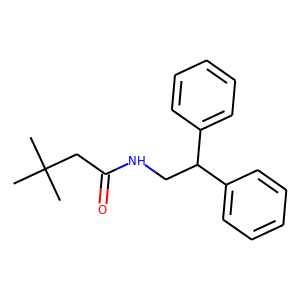

In [55]:
img

In [45]:
ms = []
for x_new in xmin:
    #model = DGLJTNNVAE(vocab, hidden_size, latent_size, depth)
    #model.load_state_dict(torch.load(opts.model_path))
    #model = cuda(model)
    tree_vec, mol_vec = x_new.chunk(2,1)
    #print(x_new.shape, tree_vec.shape, mol_vec.shape)
    #print(x_new)
    s=JT_model.decode(tree_vec, mol_vec)
    if s is not None:
        valid_smiles.append(s)
        
        current_log_P_value = Descriptors.MolLogP(MolFromSmiles(s))
        current_SA_score = -sascorer.calculateScore(MolFromSmiles(s))
        cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(s))))
        if len(cycle_list) == 0:
            cycle_length = 0
        else:
            cycle_length = max([ len(j) for j in cycle_list ])
        if cycle_length <= 6:
            cycle_length = 0
        else:
            cycle_length = cycle_length - 6

        current_cycle_score = -cycle_length

        current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
        current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
        current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)

        score = current_SA_score_normalized + current_log_P_value_normalized + current_cycle_score_normalized
        y_new=-score
        scores.append(y_new)
        real_scores.append(current_log_P_value + current_SA_score - current_cycle_score)
            

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
